<a href="https://colab.research.google.com/github/t1seo/AIFFEL/blob/master/EXPLORATION/04/Song_Lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 멋진 작사가 만들기

## 1. 데이터 다운로드

- [Kaggle: Song Lyrics](https://www.kaggle.com/paultimothymooney/poetry)

## 2. 데이터 읽어오기
- `glob` 모듈을 활용하여 모든 `txt` 파일을 읽어온 후, `raw_corpus` 리스트에 문장 단위로 저장한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import os

txt_file_path = "/content/drive/MyDrive/data/lyrics/*"

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담는다
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print(f"데이터의 크기: {len(raw_corpus)}")
print(f"Examples: \n {raw_corpus[:10]}")

데이터의 크기: 187088
Examples: 
 ['I hear you callin\', "Here I come baby"', 'To save you, oh oh', "Baby no more stallin'", 'These hands have been longing to touch you baby', "And now that you've come around, to seein' it my way", "You won't regret it baby, and you surely won't forget it baby", "It's unbelieveable how your body's calling for me", "I can just hear it callin' callin' for me My body's callin' for you", "My body's callin' for you", "My body's callin' for you"]


## 3. 데이터 정제
- `preprocessing_sentence()` 함수를 활용해 데이터를 정제
- 추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있다.
- 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하기를 권한다.

In [3]:
import re

# 입력된 문장
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6

    return sentence

In [4]:
# 정제 함수를 이용해 정제 데이터 구해보기
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: 
        continue
    if len(sentence.split()) > 15: # 토큰의 개수가 15개 넘어가면 학습 데이터에서 제외
        continue
    corpus.append(preprocess_sentence(sentence))

corpus[:10]

['<start> i hear you callin , here i come baby <end>',
 '<start> to save you , oh oh <end>',
 '<start> baby no more stallin <end>',
 '<start> these hands have been longing to touch you baby <end>',
 '<start> and now that you ve come around , to seein it my way <end>',
 '<start> you won t regret it baby , and you surely won t forget it baby <end>',
 '<start> it s unbelieveable how your body s calling for me <end>',
 '<start> i can just hear it callin callin for me my body s callin for you <end>',
 '<start> my body s callin for you <end>',
 '<start> my body s callin for you <end>']

## 4. 평가 데이터셋 분리

- `tokenize()` 함수로 데이터를 Tensor로 변환한 후, `sklearn` 모듈의 `train_test_split()` 함수를 사용해 훈련 데이터와 평가 데이터를 분리한다.
- 단어장의 크기는 **12,000 이상**으로 설정한다
- 총 데이터의 **20%를 평가 데이터셋**으로 사용한다.

### 데이터를 Tensor로 변환

In [5]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 12000, # 단어장 크기
        filters = ' ',
        oov_token = "<unk>" # 12000 단어에 포함되지 못한 단어
    )
    tokenizer.fit_on_texts(corpus) # 내부 단어장
    tensor = tokenizer.texts_to_sequences(corpus) # corpus를 Tensor로 변환
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # 입력 데이터의 시퀀스 길이를 일정하게 맞춰준다

    print(tensor)
    print(tokenizer)

    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   5 188 ...   0   0   0]
 [  2  10 579 ...   0   0   0]
 [  2  51  38 ...   0   0   0]
 ...
 [  2  43 899 ...   0   0   0]
 [  2  43  67 ...   0   0   0]
 [  2   8  82 ...   0   0   0]]


### 훈련 데이터와 평가 데이터로 분리

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

src_input = tensor[:, :-1] # tensor에서 마지막 토큰을 잘라내서 소스 문장 생성
tgt_input = tensor[:, 1:] # tensor에서 <start>를 잘라내서 타겟 문장 생성

print(src_input[0])
print(tgt_input[0])

[  2   5 188   7 798   4  93   5  67  51   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5 188   7 798   4  93   5  67  51   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [7]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=42)

In [8]:
print(f"enc_train: {enc_train.shape}")
print(f"dec_train: {dec_train.shape}")
print(f"enc_val: {enc_val.shape}")
print(f"dec_val: {dec_val.shape}")

enc_train: (134872, 32)
dec_train: (134872, 32)
enc_val: (33718, 32)
dec_val: (33718, 32)


### tf.data.Dataset 객체 생성

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1 # tokenizer가 구축한 단어장 크기 + 여기 포함되지 않은 0:<pad> 

In [10]:
# train datset
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

<BatchDataset shapes: ((256, 32), (256, 32)), types: (tf.int32, tf.int32)>

In [11]:
# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

<BatchDataset shapes: ((256, 32), (256, 32)), types: (tf.int32, tf.int32)>

## 5. 인공지능 만들기
- 모델의 `Embedding Size`와 `Hidden Size`를 조절하며 10 Epoch 안에 `val_loss` 값을 2.2 수준으로 줄 일 수 있는 모델을 설계
- Loss는 아래 제시된 Loss 함수를 그대로 사용

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) # Embedding layer
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) # LSTM layer
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) # LSTM layer
        self.linear = tf.keras.layers.Dense(vocab_size) # Dense layer

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

In [13]:
# 데이터셋에서 데이터 한 배치만 불러온다
for src_sample, tgt_sample in train_dataset.take(1): 
    break

# 한 배치만 불러온 데이터를 모델에 넣어본다
model(src_sample)

<tf.Tensor: shape=(256, 32, 12001), dtype=float32, numpy=
array([[[ 3.73724062e-04, -8.43362286e-05, -1.02122489e-04, ...,
         -1.38638032e-04, -2.44665833e-04, -1.46010816e-05],
        [ 7.07619358e-04, -2.07468911e-04, -6.56708071e-05, ...,
         -1.73437147e-04, -5.06732613e-04,  1.42590099e-04],
        [ 5.99500723e-04, -3.54654592e-04, -4.63576034e-05, ...,
         -1.44710342e-04, -8.21792230e-04,  1.70517917e-04],
        ...,
        [ 7.14552472e-04,  1.45974348e-03, -4.55857589e-05, ...,
         -2.39412929e-03,  3.92725255e-04,  6.54931704e-04],
        [ 6.96372066e-04,  1.49834610e-03, -6.98013682e-05, ...,
         -2.40531610e-03,  4.32653935e-04,  6.83644321e-04],
        [ 6.79311343e-04,  1.53259339e-03, -9.15423152e-05, ...,
         -2.41421047e-03,  4.67341713e-04,  7.08466163e-04]],

       [[ 3.73724062e-04, -8.43362286e-05, -1.02122489e-04, ...,
         -1.38638032e-04, -2.44665833e-04, -1.46010816e-05],
        [ 6.47824781e-04, -2.17768538e-04,  4

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam() # optimizer: Adam
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
526/526 [==============================] - 227s 427ms/step - loss: 1.7086 - val_loss: 1.4742
Epoch 2/10
526/526 [==============================] - 225s 428ms/step - loss: 1.4221 - val_loss: 1.3927
Epoch 3/10
526/526 [==============================] - 226s 429ms/step - loss: 1.3454 - val_loss: 1.3350
Epoch 4/10
526/526 [==============================] - 225s 428ms/step - loss: 1.2858 - val_loss: 1.2970
Epoch 5/10
526/526 [==============================] - 224s 426ms/step - loss: 1.2360 - val_loss: 1.2661
Epoch 6/10
526/526 [==============================] - 224s 426ms/step - loss: 1.1912 - val_loss: 1.2389
Epoch 7/10
526/526 [==============================] - 225s 427ms/step - loss: 1.1501 - val_loss: 1.2183
Epoch 8/10
526/526 [==============================] - 224s 426ms/step - loss: 1.1120 - val_loss: 1.1996
Epoch 9/10
526/526 [==============================] - 225s 427ms/step - loss: 1.0760 - val_loss: 1.1844
Epoch 10/10
526/526 [==============================] - 226s 430m

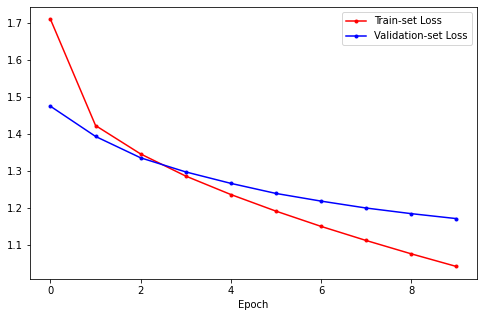

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 6. 가사 만들어보기

In [21]:
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len: 
            break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much <end> '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> i want", max_len=20)

'<start> i want to be a little selfish <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i wonder", max_len=20)

'<start> i wonder if i m in love with you <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> i think", max_len=20)

'<start> i think i could be a <unk> <end> '

In [28]:
generate_text(model, tokenizer, init_sentence="<start> she loves", max_len=20)

'<start> she loves me , i m not gonna be <end> '

## 결론
### 루브릭
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가? - 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가? - 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
3. 텍스트 생성모델이 안정적으로 학습되었는가? - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

### 회고
- 문자열 데이터를 어떻게 train 데이터와 test 데이터로 나누어서 학습시킬지
- 데이터의 전처리 과정
    - token화 
    - 사전
- LSTM 모델